In [6]:
import sys
sys.path.append("../")

from src.data.load_data import load_brent_data
from src.eda.eda_utils import plot_price_series


In [7]:
df = load_brent_data("../data/raw/brentoilprices.csv")
df.head()


d:\KAIM\brent-oil-change-point-analysis\notebooks\..\src\data\load_data.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


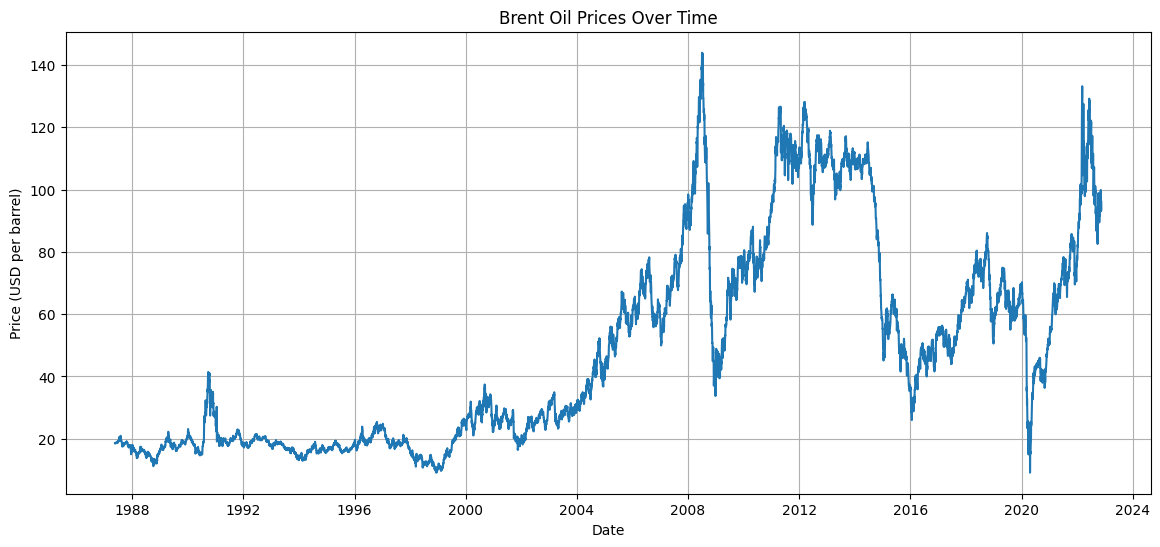

In [8]:
plot_price_series(df)


In [9]:
df.info()
df.describe()


<class 'pandas.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9011 non-null   datetime64[us]
 1   price   9011 non-null   float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 140.9 KB


,date,price
count,9011,9011.000000
mean,2005-02-10 23:46:53.760958,48.420782
min,1987-05-20 00:00:00,9.100000
25%,1996-03-20 12:00:00,19.050000
50%,2005-02-02 00:00:00,38.570000
75%,2014-01-09 12:00:00,70.090000
max,2022-11-14 00:00:00,143.950000
std,NaN,32.860110


### Initial Observations

- The dataset contains daily Brent oil prices spanning multiple decades.
- Prices exhibit long-term trends and several sharp shocks.
- Periods of heightened volatility are visible, likely linked to major global events.


## Time Series Characteristics

- **Trend**: Brent oil prices show long-term upward and downward movements,
  indicating non-stationary behavior.
- **Volatility**: Certain periods show large and frequent price swings,
  suggesting volatility clustering.
- **Structural Breaks**: Visual inspection suggests several abrupt shifts
  in price levels, motivating the use of change point models.


In [10]:
import numpy as np
from statsmodels.tsa.stattools import adfuller


In [11]:
def adf_test(series):
    result = adfuller(series.dropna())
    return {
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Critical Values": result[4]
    }

adf_test(df['price'])


{'ADF Statistic': np.float64(-1.9938560113924675),
 'p-value': np.float64(0.28927350489340287),
 'Critical Values': {'1%': np.float64(-3.4310783342658615),
  '5%': np.float64(-2.861861876398633),
  '10%': np.float64(-2.566941329781918)}}

### Stationarity Analysis

The Augmented Dickey-Fuller (ADF) test suggests that Brent oil prices
are non-stationary in levels, as expected for financial time series.
This motivates the use of transformations such as returns.


In [12]:
df['log_return'] = np.log(df['price']).diff()

df[['date', 'log_return']].dropna().head()


,date,log_return
1,1987-05-21,-0.009709
2,1987-05-22,0.005405
3,1987-05-25,0.002692
4,1987-05-26,0.001612
5,1987-05-27,-0.001612


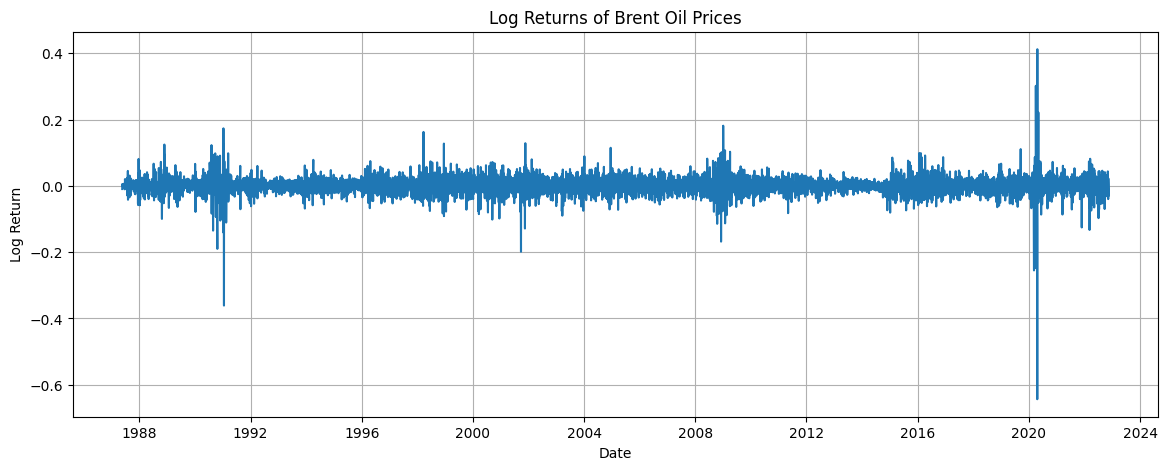

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['log_return'])
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()


### Returns and Volatility

Log returns fluctuate around zero and exhibit volatility clustering,
with periods of calm followed by periods of intense fluctuations.
This behavior supports the need for models that can capture regime
changes in the data.


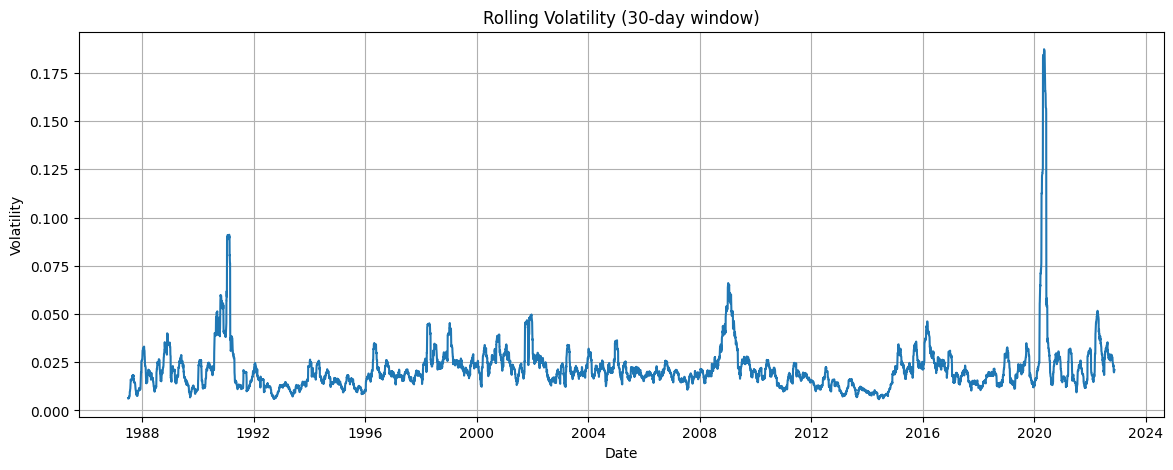

In [16]:
df['rolling_volatility'] = df['log_return'].rolling(window=30).std()

plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['rolling_volatility'])
plt.title("Rolling Volatility (30-day window)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()


## Change Point Models – Conceptual Overview

Change point models aim to detect points in time where the statistical
properties of a time series change. In this project, Bayesian change
point models will be used to identify shifts in the mean level of
Brent oil prices.

### Expected Outputs
- Posterior distribution of the change point location
- Estimated price levels before and after the change
- Uncertainty intervals around parameter estimates

### Limitations
- Detection does not guarantee causal attribution
- Results depend on model assumptions and priors
